In [1]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '../..')

import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint
from control import lqr

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import plot_importance

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from envs.env import WoundEnv, SimpleEnv
from cfgs.config import GetParameters

In [2]:
args = GetParameters()
args.alg_rl = 'ppo'
args.spt = False
# args.model_dir = '../../../../res_wound_rl/res_healnet/models/models_{}/'.format(args.alg_rl)
# args.model_dir = '../../../../res_wound_rl/res_healnet/res/models/models_{}/'.format(args.alg_rl)
args.model_dir = '../../../../res_wound_rl/res/models_08_10/models_{}/'.format(args.alg_rl)
args.data_dir = '../../../../res_wound_rl/res/data/data_{}/'.format(args.alg_rl)
args.figs_dir = '../res/figs/figs_{}/'.format(args.alg_rl)

In [3]:
env4 = SimpleEnv(args)
env5 = WoundEnv(args)

In [4]:
state_buf_ode4 = np.zeros((0, 4))
state_buf_ode5 = np.zeros((0, 500))

In [5]:
def dynamic5(state_buf, env):
    state = env.reset()
    for t in range(env.t_nums - 1):
        state_next, reward, done, info = env.step(0)
        state_buf = np.vstack((state_buf, state))
        state = state_next
    state_buf = np.vstack((state_buf, state))
    return state_buf
def dynamic4(state_buf, env):
    state = env.reset()
    for t in range(env.t_nums - 1):
        state_next, reward, done, info = env.step(np.array([0.5, 0.3, 0.1]))
        state_buf = np.vstack((state_buf, state))
        state = state_next
    state_buf = np.vstack((state_buf, state))
    return state_buf

In [6]:
state_buf_ode4 = dynamic4(state_buf_ode4, env4)
state_buf_ode5 = dynamic5(state_buf_ode5, env5)

Text(0, 0.5, 'variable values')

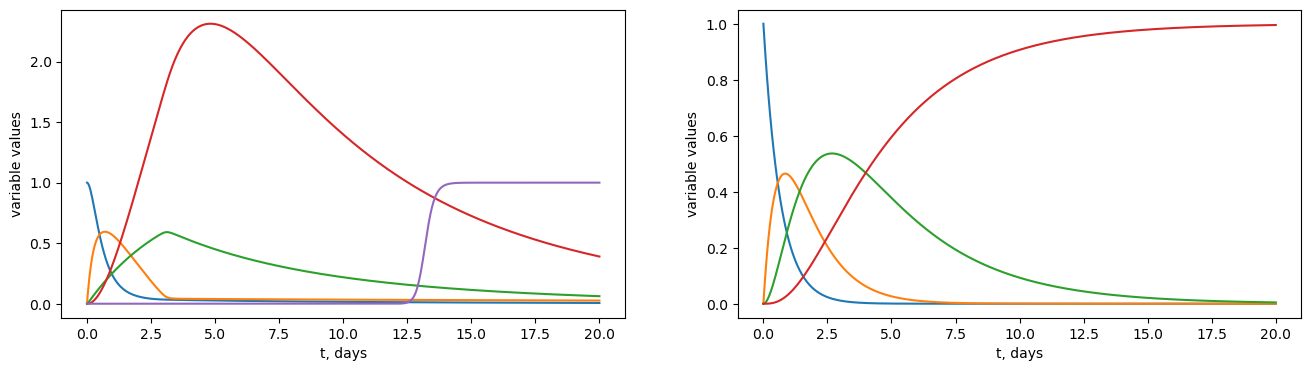

In [7]:
state_buf_ode5_3d = np.reshape(state_buf_ode5, (env5.t_nums, 5, 100))

t_range = np.linspace(0, env4.t_days, env4.t_nums) / 3
fig = plt.figure(figsize=(16, 4), num=2)
ax = fig.add_subplot(121)
ax.plot(t_range, state_buf_ode5_3d[:, 0, 0], label='hemostasis')
ax.plot(t_range, state_buf_ode5_3d[:, 1, 0], label='inflammation')
ax.plot(t_range, state_buf_ode5_3d[:, 2, 0], label='proliferation')
ax.plot(t_range, state_buf_ode5_3d[:, 3, 0], label='maturation')
ax.plot(t_range, state_buf_ode5_3d[:, 4, 0], label='maturation')
ax.set_xlabel('t, days')
ax.set_ylabel('variable values')


ax = fig.add_subplot(122)
ax.plot(t_range, state_buf_ode4[:, 0], label='hemostasis')
ax.plot(t_range, state_buf_ode4[:, 1], label='inflammation')
ax.plot(t_range, state_buf_ode4[:, 2], label='proliferation')
ax.plot(t_range, state_buf_ode4[:, 3], label='maturation')
ax.set_xlabel('t, days')
ax.set_ylabel('variable values')


In [8]:
nose_amp = 0
ns = 1
X = np.vstack([np.clip(
                state_buf_ode5 + np.random.uniform(-nose_amp, nose_amp, (state_buf_ode5.shape)), 0, 1) 
               for _ in range(ns)])
y = np.vstack([state_buf_ode4 for _ in range(ns)])

In [9]:
regressor = MultiOutputRegressor(GradientBoostingRegressor(random_state=0, n_estimators=100, max_depth=7), n_jobs=5)
regressor.fit(X, y)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=7,
                                                         random_state=0),
                     n_jobs=5)

In [10]:
X_test = X[:601, :]
X_test.shape

(601, 500)

In [11]:
X_test = X[:601, :]
state_buf_ode4_predict = np.clip(regressor.predict(X_test), 0, 10)
state_buf_ode4_predict = state_buf_ode4_predict.reshape(601, 4) 

In [12]:
sum(np.diag((state_buf_ode4_predict - state_buf_ode4).T @ (state_buf_ode4_predict - state_buf_ode4)))

7.191195368835483e-07

In [13]:
kh = 0.5
ki = 0.3
kp = 0.1
A = np.array([[-kh, 0, 0, 0],
              [kh, -ki, 0, 0],
              [0, ki, -kp, 0],
              [0, 0, kp, 0]])
x0 = np.array([1, 0, 0, 0]).reshape(-1, 1)
Ts = 0.1
TNum = 600
TScale = 3
B = np.array([[-1, 0, 0, 0],
              [1, -1, 0, 0],
              [0, 1, -1, 0],
              [0, 0, 1, 0]])
Q = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0]])
R = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
K, S, E = lqr(A, B, Q, R)

In [22]:
reward_buf = []

state5 = env5.reset()
for t in range(env4.t_nums - 1):
    # healnet/MVR transfer the wound image to the four state linear ODE, which we can optimaly compute the optimal next state
    state4_from5 = regressor.predict(state5.reshape(1, -1)).reshape(-1, 1)
    # optimaly compute the optimal next state, this is the state RL algorithm should come out a solution for wound image to follow
    state4_next_lqr = (A @ state4_from5 - B @ K @ state4_from5).reshape(-1, 1)
    
    state5_next, reward5, done5, info5 = env5.step(1)
    state4_next_from5 = regressor.predict(state5_next.reshape(1, -1)).reshape(-1, 1)
    
    reward = np.exp(sum(-(state4_next_from5 - state4_next_lqr).T @ (state4_next_from5 - state4_next_lqr)))[0]
    reward_buf.append(reward)
    print(t, reward)
    state5 = state5_next

    

0 0.011520475980342003
1 0.021104978187850492
2 0.035150419739214164
3 0.05396308186907774
4 0.07731764086267273
5 0.10454557391075786
6 0.13554999456683134
7 0.16741489361944736
8 0.19820087517468338
9 0.2260889254690431
10 0.2541217191327559
11 0.27833025377209347
12 0.29734439036445237
13 0.31583060497367893
14 0.33442467402813675
15 0.34206588345062733
16 0.3505797270939496
17 0.3581722191184741
18 0.363247193986836
19 0.3637050640204971
20 0.37164494324478015
21 0.370830357328971
22 0.3681857381011472
23 0.3650714652678213
24 0.3638114046506716
25 0.3645599672000793
26 0.35904088559586056
27 0.3556961024084087
28 0.35438343637529807
29 0.34835871042012223
30 0.339346104660765
31 0.3370298528312246
32 0.33526070563292276
33 0.3316957610282257
34 0.32125790605704435
35 0.31546418496871953
36 0.31347144505698893
37 0.307139821275744
38 0.30118077909541396
39 0.2994671342671848
40 0.2987766481417154
41 0.2952516975219701
42 0.2904381868370483
43 0.2860329710805646
44 0.284326048079004

357 0.44352814569473076
358 0.4408865145634986
359 0.43999964434483274
360 0.43933081875946534
361 0.4379138049855403
362 0.43783594774167617
363 0.4376711437331859
364 0.4374404447563771
365 0.4371905469615717
366 0.43686580287762944
367 0.43557761774713466
368 0.4352957606856126
369 0.43495021679293144
370 0.4345402279256121
371 0.43381003110406235
372 0.4334512840707164
373 0.4334836448838565
374 0.43328204655516767
375 0.4332681265385766
376 0.4326935319183269
377 0.43225913973401103
378 0.4318666438563956
379 0.4315596474624004
380 0.4314176423540439
381 0.43137302225848495
382 0.43064416317877036
383 0.4305998847932856
384 0.42936045338048223
385 0.428942859348301
386 0.4285310568638687
387 0.4283483547708233
388 0.4279944933152884
389 0.4274176366132378
390 0.4270252255409493
391 0.4272715884787257
392 0.4239426343405262
393 0.42338633067699105
394 0.4226472243795113
395 0.42103577638842843
396 0.42106913388362516
397 0.42007041580865606
398 0.4200153903714569
399 0.418796946224

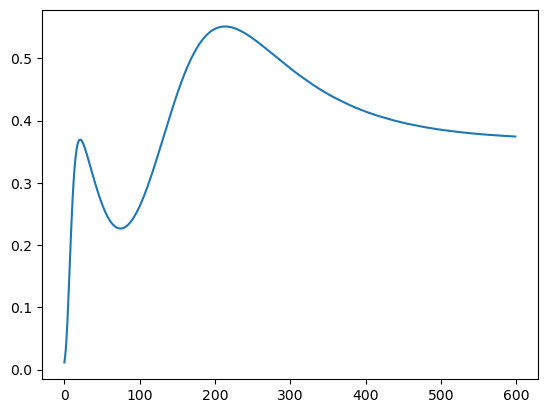

In [20]:
plt.plot(reward_buf)

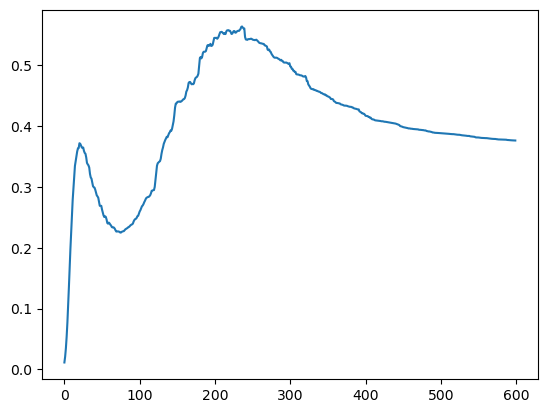

In [23]:
plt.plot(reward_buf)

In [ ]:
t_range = np.linspace(0, env4.t_days, env4.t_nums) / 3
fig = plt.figure(figsize=(16, 4), num=2)
# ax = fig.add_subplot(121)
# ax.plot(t_range, X_test[:, 0], label='hemostasis')
# ax.plot(t_range, X_test[:, 1], label='inflammation')
# ax.plot(t_range, X_test[:, 2], label='proliferation')
# ax.plot(t_range, X_test[:, 3], label='maturation')
# ax.set_xlabel('t, days')
# ax.set_ylabel('variable values')

# ax.legend()

lines = []

ax = fig.add_subplot(122)
state_buf_ode4_predict_rs = state_buf_ode4_predict.reshape(601, 4) 
state_buf_ode4_rs = y.reshape(601, 4) 
ax.plot(t_range, state_buf_ode4_rs[:, 0], linestyle='-', c='r', label='hemostasis')
ax.plot(t_range, state_buf_ode4_rs[:, 1], linestyle='-', c='g', label='inflammation')
ax.plot(t_range, state_buf_ode4_rs[:, 2], linestyle='-', c='b', label='proliferation')
lines += ax.plot(t_range, state_buf_ode4_rs[:, 3], linestyle='-', c='c', label='maturation')

ax.plot(t_range, state_buf_ode4_predict_rs[:, 0], linestyle='--', c='r')
ax.plot(t_range, state_buf_ode4_predict_rs[:, 1], linestyle='--', c='g')
ax.plot(t_range, state_buf_ode4_predict_rs[:, 2], linestyle='--', c='b')
ax.plot(t_range, state_buf_ode4_predict_rs[:, 3], linestyle='--', c='c')

ax.legend(bbox_to_anchor=(0.6, 0.8), loc='center right', borderaxespad=0)
from matplotlib.legend import Legend
leg = Legend(ax, lines, ['true trajectory', 'predicted trajectory'],
             bbox_to_anchor=(0.35, 0.89), 
             loc='center right', borderaxespad=0, frameon=True)
ax.add_artist(leg)

ax.set_xlabel('t, days')
ax.set_ylabel('variable values')

plt.tight_layout()
# plt.savefig(args.figs_dir + 'map_45ode.pdf', format='pdf')
# plt.savefig(args.figs_dir + 'map_45ode.svg', format='svg')